## Diversity Metrics on ARG Samples:
Here I just want to get a sense of what the ARG diversity looks like in our samples. I just want to get a general overview of what our datasets look like, so that I can start making figures. I will likely do my best to make some of the figures seen in the Li2021 paper in Figure 1. The first thing I think I'll do is make the ARG heatmap with the GCPM values I just calculated. 

In [2]:
import sys
sys.path.append("/dartfs/rc/lab/R/RossB/SalernoP/")

import numpy as np
import pandas as pd
from importlib import reload
import rpy2

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Calculating PAM clusters and Silhouette widths
I want to replicate Li2021 Figure 1E and generate a silhouette plot prior to plotting NMDS plots for my data. To do this I'll use the same packages as outlined in the Li2021 paper, and then once I replicate that plot I'll implement it in my own data. 


In [16]:
# dart_df = pd.read_csv('../../../DartCF_infant_meta/Results/RGI/Final_Results/dart_CF_GCPM_Results.csv')
dart_df = pd.read_csv('../../../OtherLabsPublished/Li2021/Results/RGI/Final_Results/Li_GCPM_Results.csv')
#print(dart_df.iloc[:,9:])
dart = dart_df
num_cols = dart.columns[9:]
dart[num_cols] = dart[num_cols].apply(lambda x: (x/1e6)*100)
#print(dart[num_cols])

In [17]:
from scipy.spatial import distance
calc_cols = dart[num_cols]
transposed = calc_cols.T

bc_matrix = distance.pdist(transposed.values, metric='braycurtis')
bc_square = distance.squareform(bc_matrix)
#print(bc_square)

from skbio import DistanceMatrix
from skbio.diversity import beta_diversity

# Calculate Bray-Curtis distances
bc_dm = beta_diversity("braycurtis", transposed.values, ids=transposed.index)
bc_matrix = bc_dm.data
#print(bc_matrix)

data = np.array(bc_dm.data)
sample_ids = list(bc_dm.ids)

%Rpush data sample_ids

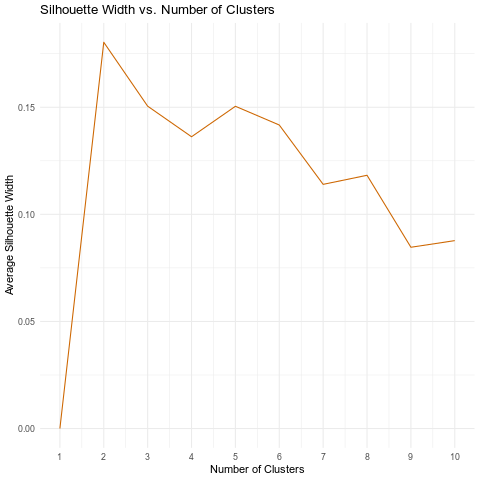

In [18]:
%%R 
library(vegan)
library(cluster)
library(fpc)
library(ggplot2)

bc_dist <- vegdist(data, method="bray")

max_clusters <- 10
sil_width <- numeric(max_clusters)

for (k in 1:max_clusters) {
  if (k == 1) {
    sil_width[k] <- 0
  } else {
    pam_fit <- pam(bc_dist, diss=TRUE, k=k)
    sil_width[k] <- mean(silhouette(pam_fit$clustering, dist=bc_dist)[,'sil_width'])
  }
}

best_k <- which.max(sil_width)

pam_fit_best <- pam(bc_dist, diss=TRUE, k=best_k)

# Create data frame with cluster numbers
sil_data <- data.frame(
  K = 1:max_clusters,
  Silhouette = sil_width
)

ggplot(sil_data, aes(x = K, y = Silhouette)) +
  geom_line(color="darkorange3") +
  labs(title = "Silhouette Width vs. Number of Clusters",
       x = "Number of Clusters",
       y = "Average Silhouette Width") +
  scale_x_continuous(breaks = 1:max_clusters) +
  theme_minimal()


### Hierarchal Clustering
I want to cluster the ARGs in each sample to make sense of the Silhouette width plots. So I'll try to replicate the findings of Figure 1D to do so. 

In [25]:
dart_df = pd.read_csv('../../../OtherLabsPublished/Li2021/Results/RGI/Final_Results/Li_GCPM_Results.csv')
dart = dart_df
dart_sub = dart.iloc[:, [0] + list(range(9, dart.shape[1]))]
summed = dart_sub.groupby(dart_sub.columns[0]).sum().reset_index()
print(summed)
%Rpush summed

                                               ARO Term  SRR14017559_gcpm  \
0     23S rRNA (adenine(2058)-N(6))-methyltransferas...               0.0   
1                                           AAC(2')-IIa               0.0   
2                                            AAC(2')-Ia               0.0   
3                                            AAC(2')-Ic               0.0   
4                                           AAC(3)-IIIa               0.0   
...                                                 ...               ...   
2007                                               vgbB               0.0   
2008                                               vmlR               0.0   
2009                                 y56 beta-lactamase               0.0   
2010                                               ykkC               0.0   
2011                                               ykkD               0.0   

      SRR14017380_gcpm  SRR14017618_gcpm  SRR14017330_gcpm  SRR14000971_gcp

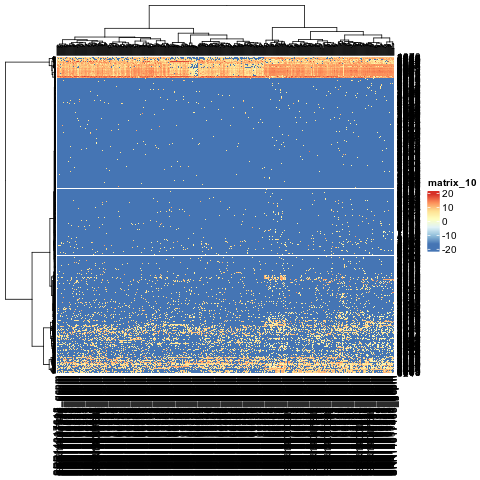

In [65]:
%%R
library(ComplexHeatmap)
# 1. Collapse data
collapsed_df <- aggregate(. ~ `ARO Term` , data = summed, sum) # assuming 'V1' is the name of your gene column

# Filter genes where sum of GCPM across all samples is greater than 100
filtered_data <- collapsed_df[apply(collapsed_df[, -1], 1, sum) > 100, ]

# Convert filtered data to matrix
data_for_clustering <- as.matrix(filtered_data[, -1])

# Add a small constant to avoid log2(0)
constant_to_add <- 1e-5
log2_transformed_data <- log2(data_for_clustering + constant_to_add)
scaled_log2_data <- t(scale(log2_transformed_data))

# transposed_data <- t(scaled_log2_data)

# Compute the distance matrix for the transposed data
dist_matrix_transposed <- dist(scaled_log2_data, method = "euclidean")

# Cluster for the transposed data
row_hclust_transposed = hclust(dist_matrix_transposed, method = "complete")

# Create heatmap for the transposed data
# Heatmap(transposed_data, 
#         name = "transposed_data",
#         cluster_rows = row_hclust_transposed, 
#         cluster_columns = TRUE)

pheatmap(log2_transformed_data, clustering_distance_rows = NULL, clustering_distance_cols = dist_matrix_log2, clustering_method = "ward.D2")


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   33 
TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE 
  34   35   36   38   39   40   42   43   44   45   46   47   48   49   50   51 
TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE 
  52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67 
TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE 
  68   69   70   71   72   73   74   76   77   78   79   80   81   82   83   84 
TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE 
  85   86   88   89   90   92   93   94   95   96   98   99  100  101  104  106 
TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE 
 107  108  109  110  111  11

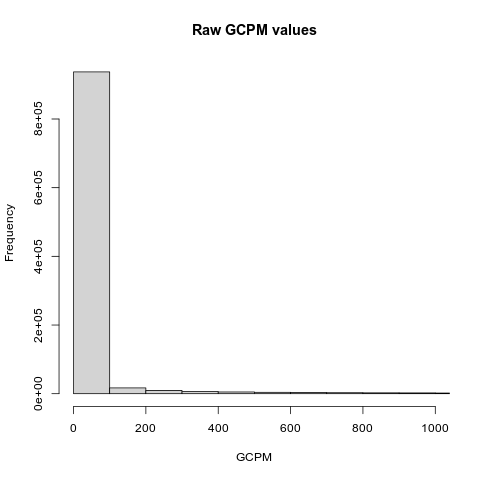

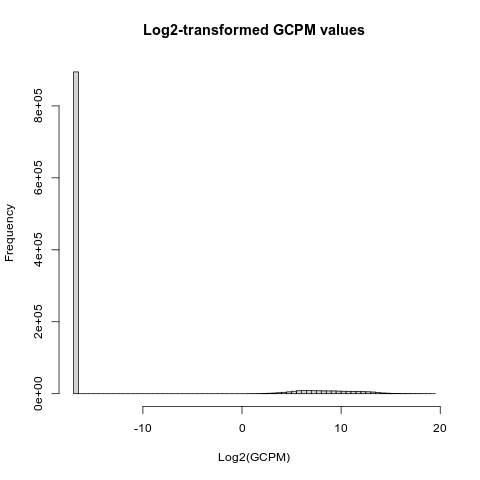

In [56]:
%%R
hist(data_for_clustering, main="Raw GCPM values", xlab="GCPM", breaks=10000, xlim=c(0, 1000))
hist(log2_transformed_data, main="Log2-transformed GCPM values", xlab="Log2(GCPM)", breaks=100)
apply(filtered_data[, -1], 1, sum) > 100



/dartfs-hpc/rc/home/d/f00415d/.local/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


IndexError: positional indexers are out-of-bounds

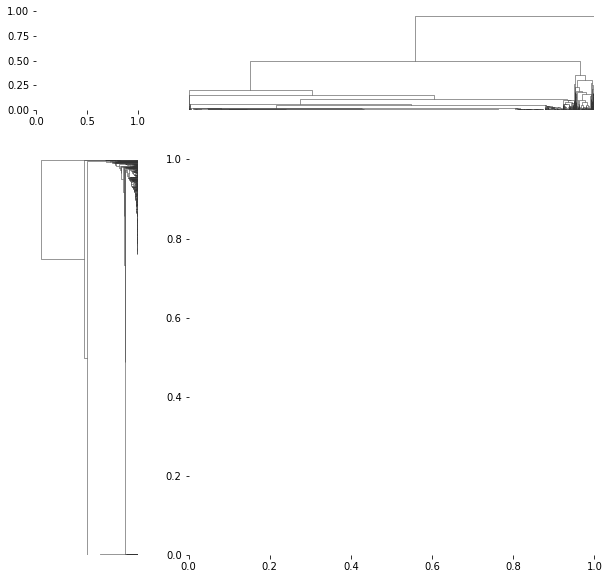

In [60]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'collapsed_df' is your dataframe

# Separate gene names and numeric data
gene_names = summed.iloc[:, 0]  # First column with gene names
data_for_clustering = summed.iloc[:, 1:]  # Numeric data columns

# Calculate the linkage matrix using Euclidean distance
linked = linkage(data_for_clustering, 'ward')

# Using Seaborn's Clustermap which combines heatmap + dendrogram
sns.clustermap(data_for_clustering, row_cluster=True, col_linkage=linked, standard_scale=1, cmap='viridis')

# To display the plot
plt.show()



### Shannon Diversity
Now I want to calculate shannon diversity so that I can take a look at alpha diversity

In [ ]:
dart=dart.fillna(0)
def shannon(df):
    calc = df.apply(lambda x: -np.sum(np.log((x/x.sum())**(x/x.sum()))), axis=0)
    return(calc)
dart_shannon = shannon(dart[num_cols])
result_df = pd.DataFrame({'Shannon': dart_shannon})

#print(result_df)

### ARG Richness
I don't quite understand how the paper calculated ARG richness, so I will try a few things to figure that out and replicate their findings in Figure 1G

In [38]:
li_df = pd.read_csv('/dartfs/rc/lab/R/RossB/OtherLabsPublished/Li2021/Results/RGI/Final_Results/Li_GCPM_Results.csv')
cols = li_df.iloc[:,9:]
threshold = 100
presence = (cols > threshold).astype(int)
arg_richness = presence.sum(axis=0)
print(arg_richness)

SRR14017559_gcpm    163
SRR14017380_gcpm    132
SRR14017618_gcpm    131
SRR14017330_gcpm    175
SRR14000971_gcpm    162
                   ... 
SRR14000840_gcpm    167
SRR14000793_gcpm    184
SRR14017498_gcpm    215
SRR14017478_gcpm    137
SRR14000972_gcpm    157
Length: 660, dtype: int64
